# 樣型識別 CH10

dl-for-timeseries

資工四 B0729003 何妍霖

# Deep learning for timeseries

## Different kinds of timeseries tasks

## A temperature-forecasting example

In [1]:
# !wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
# !unzip jena_climate_2009_2016.csv.zip

**Inspecting the data of the Jena weather dataset**

In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

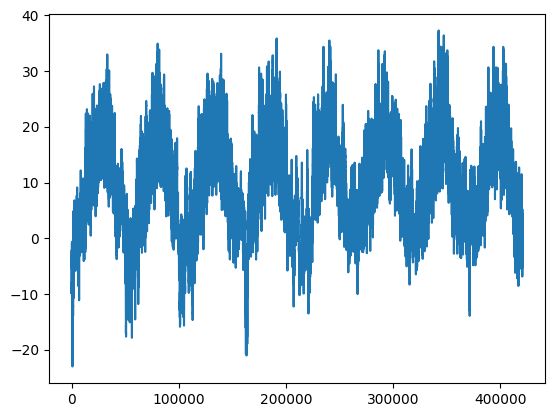

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

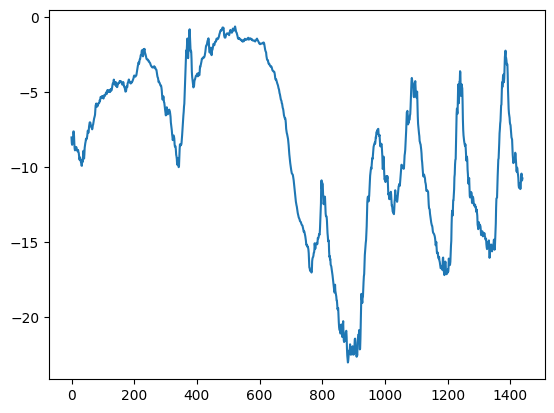

In [5]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [8]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

C:\Users\csie\anaconda3\envs\py37\lib\site-packages\requests\__init__.py:114: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (None)/charset_normalizer (3.0.0) doesn't match a supported version!
  RequestsDependencyWarning,


[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [9]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [10]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [11]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 15s 13ms/step - loss: 13.6825 - mae: 2.8566 - val_loss: 11.3076 - val_mae: 2.6461
Epoch 2/10
819/819 [==============================] - 11s 13ms/step - loss: 9.6560 - mae: 2.4428 - val_loss: 11.3859 - val_mae: 2.6620
Epoch 3/10
819/819 [==============================] - 10s 12ms/step - loss: 8.7863 - mae: 2.3291 - val_loss: 10.4269 - val_mae: 2.5800
Epoch 4/10
819/819 [==============================] - 9s 12ms/step - loss: 8.2822 - mae: 2.2620 - val_loss: 10.3173 - val_mae: 2.5703
Epoch 5/10
819/819 [==============================] - 9s 11ms/step - loss: 7.9223 - mae: 2.2149 - val_loss: 11.0121 - val_mae: 2.6595
Epoch 6/10
819/819 [==============================] - 9s 11ms/step - loss: 7.6372 - mae: 2.1749 - val_loss: 11.1728 - val_mae: 2.6743
Epoch 7/10
819/819 [==============================] - 9s 11ms/step - loss: 7.3970 - mae: 2.1390 - val_loss: 10.5479 - val_mae: 2.5922
Epoch 8/10
819/819 [==============================] - 9s 1

**Plotting results**

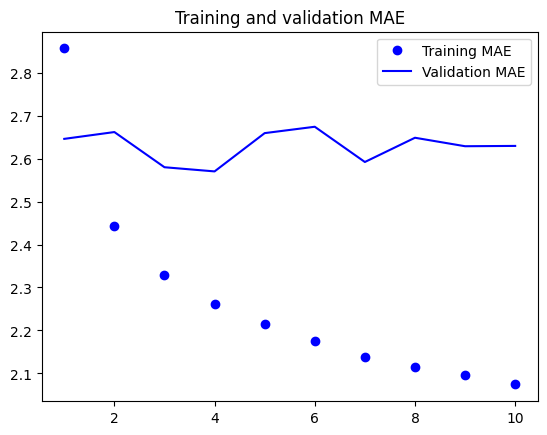

In [13]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Let's try a 1D convolutional model

In [14]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 32s 16ms/step - loss: 22.2658 - mae: 3.6969 - val_loss: 15.5968 - val_mae: 3.0844
Epoch 2/10
819/819 [==============================] - 14s 17ms/step - loss: 14.7376 - mae: 3.0458 - val_loss: 18.5614 - val_mae: 3.4309
Epoch 3/10
819/819 [==============================] - 14s 17ms/step - loss: 13.4087 - mae: 2.8990 - val_loss: 14.7604 - val_mae: 3.0224
Epoch 4/10
819/819 [==============================] - 14s 17ms/step - loss: 12.7195 - mae: 2.8270 - val_loss: 16.5157 - val_mae: 3.1759
Epoch 5/10
819/819 [==============================] - 15s 19ms/step - loss: 12.2035 - mae: 2.7677 - val_loss: 15.8580 - val_mae: 3.1378
Epoch 6/10
819/819 [==============================] - 16s 19ms/step - loss: 11.8386 - mae: 2.7272 - val_loss: 15.4646 - val_mae: 3.0867
Epoch 7/10
819/819 [==============================] - 15s 18ms/step - loss: 11.5138 - mae: 2.6877 - val_loss: 15.3268 - val_mae: 3.0671
Epoch 8/10
819/819 [============================

### A first recurrent baseline

**A simple LSTM-based model**

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 24s 16ms/step - loss: 40.0036 - mae: 4.5943 - val_loss: 12.3297 - val_mae: 2.6916
Epoch 2/10
819/819 [==============================] - 11s 14ms/step - loss: 11.1883 - mae: 2.6024 - val_loss: 9.6738 - val_mae: 2.4237
Epoch 3/10
819/819 [==============================] - 11s 14ms/step - loss: 10.0222 - mae: 2.4719 - val_loss: 9.4600 - val_mae: 2.3887
Epoch 4/10
819/819 [==============================] - 12s 14ms/step - loss: 9.5868 - mae: 2.4155 - val_loss: 9.4919 - val_mae: 2.3869
Epoch 5/10
819/819 [==============================] - 12s 14ms/step - loss: 9.2365 - mae: 2.3699 - val_loss: 9.4008 - val_mae: 2.3787
Epoch 6/10
819/819 [==============================] - 12s 14ms/step - loss: 8.9621 - mae: 2.3355 - val_loss: 9.5834 - val_mae: 2.4082
Epoch 7/10
819/819 [==============================] - 12s 14ms/step - loss: 8.7625 - mae: 2.3074 - val_loss: 9.7988 - val_mae: 2.4307
Epoch 8/10
819/819 [==============================] - 12s 

## Understanding recurrent neural networks

**NumPy implementation of a simple RNN**

In [16]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### A recurrent layer in Keras

**An RNN layer that can process sequences of any length**

In [17]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**An RNN layer that returns only its last output step**

In [18]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**An RNN layer that returns its full output sequence**

In [19]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**Stacking RNN layers**

In [20]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [21]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 769s 936ms/step - loss: 28.7861 - mae: 3.9573 - val_loss: 10.0107 - val_mae: 2.4531
Epoch 2/50
819/819 [==============================] - 767s 937ms/step - loss: 14.9518 - mae: 3.0028 - val_loss: 10.1503 - val_mae: 2.4749
Epoch 3/50
819/819 [==============================] - 765s 934ms/step - loss: 13.9738 - mae: 2.8989 - val_loss: 9.3681 - val_mae: 2.3818
Epoch 4/50
819/819 [==============================] - 769s 939ms/step - loss: 13.3179 - mae: 2.8295 - val_loss: 9.3685 - val_mae: 2.3696
Epoch 5/50
819/819 [==============================] - 765s 934ms/step - loss: 12.7746 - mae: 2.7715 - val_loss: 9.7009 - val_mae: 2.4173
Epoch 6/50
819/819 [==============================] - 765s 934ms/step - loss: 12.3816 - mae: 2.7265 - val_loss: 9.4406 - val_mae: 2.3753
Epoch 7/50
819/819 [==============================] - 771s 941ms/step - loss: 11.9580 - mae: 2.6843 - val_loss: 10.0104 - val_mae: 2.4597
Epoch 8/50
819/819 [==================

In [22]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

In [23]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/50
819/819 [==============================] - 1478s 2s/step - loss: 26.2070 - mae: 3.7591 - val_loss: 9.3807 - val_mae: 2.3654
Epoch 2/50
819/819 [==============================] - 1483s 2s/step - loss: 14.0053 - mae: 2.9007 - val_loss: 9.2778 - val_mae: 2.3586
Epoch 3/50
819/819 [==============================] - 1478s 2s/step - loss: 13.2252 - mae: 2.8168 - val_loss: 9.6928 - val_mae: 2.4170
Epoch 4/50
819/819 [==============================] - 1489s 2s/step - loss: 12.7195 - mae: 2.7629 - val_loss: 9.6942 - val_mae: 2.4198
Epoch 5/50
819/819 [==============================] - 1479s 2s/step - loss: 12.2302 - mae: 2.7137 - val_loss: 9.2012 - val_mae: 2.3689
Epoch 6/50
819/819 [==============================] - 1472s 2s/step - loss: 11.8454 - mae: 2.6701 - val_loss: 9.2720 - val_mae: 2.3526
Epoch 7/50
819/819 [==============================] - 1489s 2s/step - loss: 11.4158 - mae: 2.6261 - val_loss: 9.0893 - val_mae: 2.3244
Epoch 8/50
819/819 [==============================] - 1

### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [24]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 18s 19ms/step - loss: 26.3564 - mae: 3.6888 - val_loss: 10.3902 - val_mae: 2.5053
Epoch 2/10
819/819 [==============================] - 15s 18ms/step - loss: 9.6119 - mae: 2.4159 - val_loss: 9.9393 - val_mae: 2.4441
Epoch 3/10
819/819 [==============================] - 15s 18ms/step - loss: 8.8363 - mae: 2.3114 - val_loss: 9.7469 - val_mae: 2.4192
Epoch 4/10
819/819 [==============================] - 15s 18ms/step - loss: 8.2852 - mae: 2.2381 - val_loss: 9.4620 - val_mae: 2.3759
Epoch 5/10
819/819 [==============================] - 15s 18ms/step - loss: 7.7920 - mae: 2.1720 - val_loss: 10.1435 - val_mae: 2.4589
Epoch 6/10
819/819 [==============================] - 15s 19ms/step - loss: 7.4583 - mae: 2.1294 - val_loss: 11.1191 - val_mae: 2.5526
Epoch 7/10
819/819 [==============================] - 15s 18ms/step - loss: 7.1727 - mae: 2.0884 - val_loss: 10.3283 - val_mae: 2.4638
Epoch 8/10
819/819 [==============================] - 15s

### Going even further

## Summary